In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import warnings
from pathlib import Path
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Load Excel file
file_path = "../data/energy_forecasting.xlsx"
data = pd.ExcelFile(file_path)

# Load datasets
load_history = pd.read_excel(data, sheet_name='load_history')
temp_history = pd.read_excel(data, sheet_name='temperature_history')
holiday_list = pd.read_excel(data, sheet_name='holiday_list')  
submission_template = pd.read_excel(data, sheet_name='submission_template')

# Handle missing values
load_history.fillna(load_history.select_dtypes(include=['number']).mean(), inplace=True)
temp_history.fillna(temp_history.select_dtypes(include=['number']).mean(), inplace=True)

# where to save reports (notebook is in notebooks/)
REPORT_DIR = Path("../reports")
FIG_DIR = REPORT_DIR / "figures"
REPORT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# holders for per-zone metrics
zone_names, rmse_list, mae_list, r2_list = [], [], [], []

# optional: keep R² readable
def safe_r2(x, floor=-10.0):
    if not np.isfinite(x):
        return np.nan
    return max(float(x), floor)

In [3]:
# Create Lag Features for Load Data
load_history['lag_1'] = load_history['Total'].shift(1)
load_history['lag_24'] = load_history['Total'].shift(24)

In [4]:
# Merge temperature and load history using datetime
merged_data = pd.merge(load_history, temp_history, on=['month', 'day', 'week', 'hour'])

In [5]:
merged_data.head()

,t_x,year_x,month,day,week,hour,1_x,2_x,3_x,4_x,...,year_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y
0,1,2004,1,1,Thurs,1,66025.0,16908.0,126314.0,136288.0,...,2004,45.0,55.0,47.0,53.0,54.0,51.0,53.0,54.0,52.0
1,2,2004,1,1,Thurs,2,64655.0,16505.0,123368.0,133110.0,...,2004,41.0,55.0,45.0,51.0,52.0,51.0,52.0,53.0,53.0
2,3,2004,1,1,Thurs,3,63898.0,16572.0,119247.0,128663.0,...,2004,40.0,54.0,44.0,49.0,50.0,49.0,51.0,50.0,51.0
3,4,2004,1,1,Thurs,4,64078.0,16928.0,117562.0,126846.0,...,2004,39.0,50.0,39.0,45.0,46.0,48.0,47.0,49.0,43.0
4,5,2004,1,1,Thurs,5,65734.0,17119.0,118398.0,127747.0,...,2004,43.0,48.0,39.0,43.0,42.0,49.0,47.0,44.0,39.0


In [6]:
holiday_2008 = ['2008-01-01','2008-01-21', '2008-02-18', '2008-05-26', '2008-07-04', '2008-09-01']
hoilday_2008 = [datetime.strptime(date, '%Y-%m-%d') for date in holiday_2008]

In [7]:
merged_data['is_holiday'] = merged_data.apply(lambda row: 1 if datetime(row['year_x'], row['month'], row['day']) in holiday_2008 else 0, axis=1)

In [8]:
merged_data.tail(100)

,t_x,year_x,month,day,week,hour,1_x,2_x,3_x,4_x,...,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,is_holiday
39308,39309,2008,6,25,Wed,21,62422.271101,18733.412207,173947.926886,187685.829281,...,63.565189,68.316972,63.393349,64.665622,68.831677,65.299516,67.380275,67.518603,67.855861,0
39309,39310,2008,6,25,Wed,22,62422.271101,18733.412207,173947.926886,187685.829281,...,63.565189,68.316972,63.393349,64.665622,68.831677,65.299516,67.380275,67.518603,67.855861,0
39310,39311,2008,6,25,Wed,23,62422.271101,18733.412207,173947.926886,187685.829281,...,63.565189,68.316972,63.393349,64.665622,68.831677,65.299516,67.380275,67.518603,67.855861,0
39311,39312,2008,6,25,Wed,24,62422.271101,18733.412207,173947.926886,187685.829281,...,63.565189,68.316972,63.393349,64.665622,68.831677,65.299516,67.380275,67.518603,67.855861,0
39312,39313,2008,6,26,Thurs,1,62422.271101,18733.412207,173947.926886,187685.829281,...,63.565189,68.316972,63.393349,64.665622,68.831677,65.299516,67.380275,67.518603,67.855861,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39403,39404,2008,6,29,Sun,20,62422.271101,18733.412207,173947.926886,187685.829281,...,63.565189,68.316972,63.393349,64.665622,68.831677,65.299516,67.380275,67.518603,67.855861,0
39404,39405,2008,6,29,Sun,21,62422.271101,18733.412207,173947.926886,187685.829281,...,63.565189,68.316972,63.393349,64.665622,68.831677,65.299516,67.380275,67.518603,67.855861,0
39405,39406,2008,6,29,Sun,22,62422.271101,18733.412207,173947.926886,187685.829281,...,63.565189,68.316972,63.393349,64.665622,68.831677,65.299516,67.380275,67.518603,67.855861,0
39406,39407,2008,6,29,Sun,23,62422.271101,18733.412207,173947.926886,187685.829281,...,63.565189,68.316972,63.393349,64.665622,68.831677,65.299516,67.380275,67.518603,67.855861,0


In [9]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39408 entries, 0 to 39407
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   t_x         39408 non-null  int64  
 1   year_x      39408 non-null  int64  
 2   month       39408 non-null  int64  
 3   day         39408 non-null  int64  
 4   week        39408 non-null  object 
 5   hour        39408 non-null  int64  
 6   1_x         39408 non-null  float64
 7   2_x         39408 non-null  float64
 8   3_x         39408 non-null  float64
 9   4_x         39408 non-null  float64
 10  5_x         39408 non-null  float64
 11  6_x         39408 non-null  float64
 12  7_x         39408 non-null  float64
 13  8_x         39408 non-null  float64
 14  9_x         39408 non-null  float64
 15  10          39408 non-null  float64
 16  11          39408 non-null  float64
 17  12          39408 non-null  float64
 18  13          39408 non-null  float64
 19  14          39408 non-nul

In [10]:
zone_columns = [f'{i}_x' for i in range(1, 10)] + [i for i in range(10, 16)]

In [11]:
zone_columns

['1_x',
 '2_x',
 '3_x',
 '4_x',
 '5_x',
 '6_x',
 '7_x',
 '8_x',
 '9_x',
 10,
 11,
 12,
 13,
 14,
 15]

In [12]:
week_mapping = {'Mon': 1, 'Tues': 2, 'Wed': 3, 'Thurs': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7}
merged_data['week'] = merged_data['week'].map(week_mapping)

In [13]:
merged_data.head()

,t_x,year_x,month,day,week,hour,1_x,2_x,3_x,4_x,...,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,is_holiday
0,1,2004,1,1,4.0,1,66025.0,16908.0,126314.0,136288.0,...,45.0,55.0,47.0,53.0,54.0,51.0,53.0,54.0,52.0,0
1,2,2004,1,1,4.0,2,64655.0,16505.0,123368.0,133110.0,...,41.0,55.0,45.0,51.0,52.0,51.0,52.0,53.0,53.0,0
2,3,2004,1,1,4.0,3,63898.0,16572.0,119247.0,128663.0,...,40.0,54.0,44.0,49.0,50.0,49.0,51.0,50.0,51.0,0
3,4,2004,1,1,4.0,4,64078.0,16928.0,117562.0,126846.0,...,39.0,50.0,39.0,45.0,46.0,48.0,47.0,49.0,43.0,0
4,5,2004,1,1,4.0,5,65734.0,17119.0,118398.0,127747.0,...,43.0,48.0,39.0,43.0,42.0,49.0,47.0,44.0,39.0,0


In [14]:
features = merged_data.drop(columns = zone_columns + ['Total'])
target = merged_data[zone_columns]

In [15]:
features

,t_x,year_x,month,day,week,hour,lag_1,lag_24,t_y,year_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,is_holiday
0,1,2004,1,1,4.0,1,NaN,NaN,1,2004,45.000000,55.000000,47.000000,53.000000,54.000000,51.000000,53.000000,54.000000,52.000000,0
1,2,2004,1,1,4.0,2,9.760220e+05,NaN,2,2004,41.000000,55.000000,45.000000,51.000000,52.000000,51.000000,52.000000,53.000000,53.000000,0
2,3,2004,1,1,4.0,3,9.409290e+05,NaN,3,2004,40.000000,54.000000,44.000000,49.000000,50.000000,49.000000,51.000000,50.000000,51.000000,0
3,4,2004,1,1,4.0,4,9.113600e+05,NaN,4,2004,39.000000,50.000000,39.000000,45.000000,46.000000,48.000000,47.000000,49.000000,43.000000,0
4,5,2004,1,1,4.0,5,9.037480e+05,NaN,5,2004,43.000000,48.000000,39.000000,43.000000,42.000000,49.000000,47.000000,44.000000,39.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39403,39404,2008,6,29,7.0,20,1.206215e+06,1.206215e+06,39404,2008,63.565189,68.316972,63.393349,64.665622,68.831677,65.299516,67.380275,67.518603,67.855861,0
39404,39405,2008,6,29,7.0,21,1.206215e+06,1.206215e+06,39405,2008,63.565189,68.316972,63.393349,64.665622,68.831677,65.299516,67.380275,67.518603,67.855861,0
39405,39406,2008,6,29,7.0,22,1.206215e+06,1.206215e+06,39406,2008,63.565189,68.316972,63.393349,64.665622,68.831677,65.299516,67.380275,67.518603,67.855861,0
39406,39407,2008,6,29,7.0,23,1.206215e+06,1.206215e+06,39407,2008,63.565189,68.316972,63.393349,64.665622,68.831677,65.299516,67.380275,67.518603,67.855861,0


In [16]:
target

,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10,11,12,13,14,15
0,66025.000000,16908.000000,126314.000000,136288.000000,539.000000,6884.000000,133143.00000,136288.000000,3179.000000,75298.000000,23394.000000,90755.000000,118433.000000,20728.000000,21846.000000
1,64655.000000,16505.000000,123368.000000,133110.000000,512.000000,6651.000000,129964.00000,133110.000000,3011.000000,67423.000000,22155.000000,86754.000000,112535.000000,19721.000000,21455.000000
2,63898.000000,16572.000000,119247.000000,128663.000000,505.000000,6580.000000,125772.00000,128663.000000,3008.000000,64105.000000,21431.000000,84298.000000,108490.000000,19075.000000,21053.000000
3,64078.000000,16928.000000,117562.000000,126846.000000,503.000000,6709.000000,124217.00000,126846.000000,2969.000000,63916.000000,21390.000000,84340.000000,107279.000000,18896.000000,21269.000000
4,65734.000000,17119.000000,118398.000000,127747.000000,499.000000,7032.000000,125375.00000,127747.000000,3276.000000,75907.000000,21619.000000,86142.000000,108925.000000,19365.000000,21885.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39403,62422.271101,18733.412207,173947.926886,187685.829281,555.400204,7857.000459,181749.18499,187685.829281,3836.972401,67700.523012,32130.482365,107957.674643,133229.314067,19768.693527,20954.035627
39404,62422.271101,18733.412207,173947.926886,187685.829281,555.400204,7857.000459,181749.18499,187685.829281,3836.972401,67700.523012,32130.482365,107957.674643,133229.314067,19768.693527,20954.035627
39405,62422.271101,18733.412207,173947.926886,187685.829281,555.400204,7857.000459,181749.18499,187685.829281,3836.972401,67700.523012,32130.482365,107957.674643,133229.314067,19768.693527,20954.035627
39406,62422.271101,18733.412207,173947.926886,187685.829281,555.400204,7857.000459,181749.18499,187685.829281,3836.972401,67700.523012,32130.482365,107957.674643,133229.314067,19768.693527,20954.035627


In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

In [18]:
zone_predictions = []

zone_rmse = []

zone_mae = []

zone_r2 = []

for zone_column in zone_columns:
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train, y_train[zone_column])

    # predictions on your held-out test
    y_pred_zone = model.predict(X_test)
    y_true_zone = y_test[zone_column].to_numpy().ravel()
    y_pred_zone = np.asarray(y_pred_zone).ravel()

    # metrics for test
    rmse = root_mean_squared_error(y_true_zone, y_pred_zone)
    mae  = mean_absolute_error(y_true_zone, y_pred_zone)
    r2   = safe_r2(r2_score(y_true_zone, y_pred_zone))

    zone_rmse.append(rmse)
    zone_mae.append(mae)
    zone_r2.append(r2)
    zone_names.append(zone_column)
    rmse_list.append(float(rmse))
    mae_list.append(float(mae))
    r2_list.append(float(r2))

    print(f"{zone_column}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={'N/A' if np.isnan(r2) else f'{r2:.4f}'}")

    n_plot = min(168, len(y_true_zone))
    plt.figure()
    plt.plot(range(n_plot), y_true_zone[-n_plot:], label="actual")
    plt.plot(range(n_plot), y_pred_zone[-n_plot:], label="forecast")
    plt.title(f"{zone_column} - XGBoost forecast vs actual")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{zone_column}_xgb_forecast.png", dpi=150)
    plt.close()

    zone_forecast = model.predict(features[-168:])
    zone_predictions.append(zone_forecast)

zone_predictions_a = np.array(zone_predictions).T 

1_x: RMSE=3918.1154, MAE=2943.7078, R²=0.9360
2_x: RMSE=1235.9291, MAE=904.5650, R²=0.9549
3_x: RMSE=4451.8424, MAE=3371.5427, R²=0.9839
4_x: RMSE=4803.5322, MAE=3637.8877, R²=0.9839
5_x: RMSE=31.7846, MAE=22.3831, R²=0.9328
6_x: RMSE=463.5535, MAE=337.6346, R²=0.9688
7_x: RMSE=4657.1428, MAE=3530.8093, R²=0.9845
8_x: RMSE=4803.5322, MAE=3637.8877, R²=0.9839
9_x: RMSE=195.7908, MAE=147.0759, R²=0.9624
10: RMSE=12895.5355, MAE=9111.7281, R²=0.5357
11: RMSE=1774.2756, MAE=1214.0288, R²=0.9890
12: RMSE=4544.4586, MAE=3408.1624, R²=0.9783
13: RMSE=7001.3698, MAE=5158.4472, R²=0.9741
14: RMSE=1191.1073, MAE=879.8737, R²=0.9432
15: RMSE=1777.0784, MAE=1333.3308, R²=0.9401


- RMSE and MAE should be smaller for better model
- R2 should be close to 1

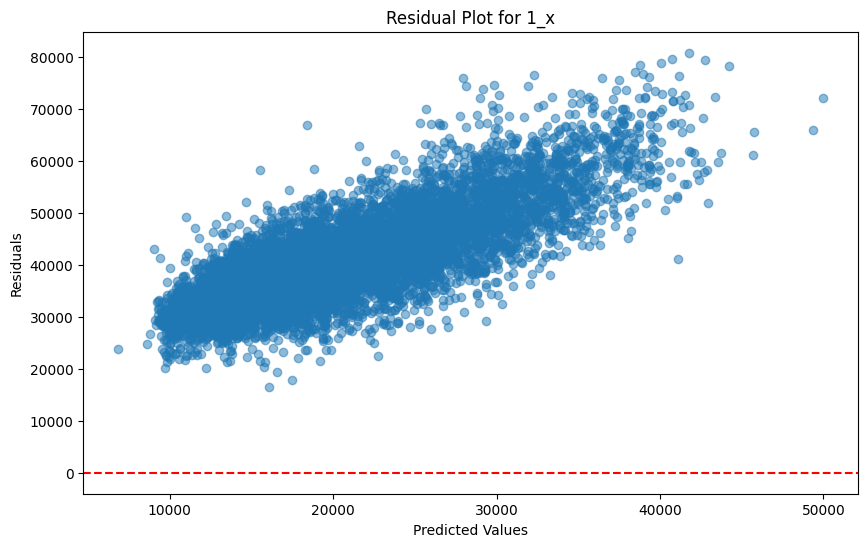

In [19]:
zone_to_viz = zone_columns[0]
predictions = model.predict(X_test)
residuals = y_test[zone_to_viz] - predictions
plt.figure(figsize = (10, 6))
plt.scatter(predictions, residuals, alpha = 0.5)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Residual Plot for {zone_to_viz}')
plt.show()

- The model tends to underestimate the actual values for higher predictions
- On the basis of the upward trend

In [20]:
avg_rmse = float(np.nanmean(rmse_list))
avg_mae  = float(np.nanmean(mae_list))
avg_r2   = float(np.nanmean(r2_list))

with open(REPORT_DIR / "metrics_xgboost.txt", "w") as f:
    f.write("XGBoost - Local Validation\n")
    f.write(f"Zones evaluated: {len(zone_names)}\n\n")
    f.write(f"Avg RMSE: {avg_rmse:.4f}\n")
    f.write(f"Avg MAE : {avg_mae:.4f}\n")
    f.write(f"Avg R²  : {avg_r2:.4f}\n\n")
    f.write("Per-zone metrics:\n")
    for z, r, m, r2 in zip(zone_names, rmse_list, mae_list, r2_list):
        r2_str = "N/A" if np.isnan(r2) else f"{r2:.4f}"
        f.write(f"{z}: RMSE={r:.4f}, MAE={m:.4f}, R²={r2_str}\n")

print("XGBoost averages ->",
      f"RMSE={avg_rmse:.4f}  MAE={avg_mae:.4f}  R²={avg_r2:.4f}")

XGBoost averages -> RMSE=3583.0032  MAE=2642.6043  R²=0.9367
